In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import glob
from tqdm import tqdm
import mpltern
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import plasma_r, plasma
from matplotlib.colors import Normalize
import sys, os, time
sys.path.append('../..')
import pyzx as zx
from benchmarking import benchmark
sys.path.append('/Users/calum/Developer/pyzx-heuristics-master')
import pyzx_heur as zx_heuristics
rc_fonts = {
    "text.usetex": True,
    "font.size": 20,
    'axes.titlesize': 17,
    "axes.labelsize": 17,
    "legend.fontsize": 17,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'figure.titlesize': 20,
    'mathtext.default': 'regular',
    'text.latex.preamble': r"\usepackage{bm}",
}
mpl.rcParams.update(rc_fonts)

In [2]:
strategy_df = pd.read_csv('optimisation_data/strategy_df.csv')
print(len(strategy_df))
strategy_df.head(1)

1161


,strategy,rep,max_lc_unfusions,max_p_unfusions,qubits,depth,pt,pcnot,initial_gate_count,initial_2Q_count,initial_T_count,final_gate_count,final_2Q_count,final_T_count,optimisation_time,2Q_reduction,gate_reduction
0,full_reduce,0,NaN,NaN,10,1000,0.0,0.3,1000,302,0,125,89,0,0.051331,70.529801,87.5


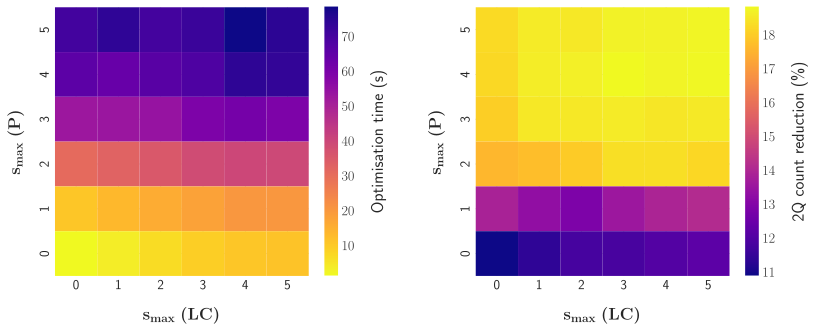

In [4]:
sdf_cflow = strategy_df[strategy_df['strategy'] == 'cFlow']

def has_all_combinations(group):
    return set((i, j) for i in range(6) for j in range(6)) == set(tuple(row) for row in group[['max_lc_unfusions', 'max_p_unfusions']].values)

filtered_sdf_cflow = sdf_cflow.groupby(['rep', 'qubits', 'depth', 'pt', 'pcnot']).filter(has_all_combinations)

pivot_time = filtered_sdf_cflow.pivot_table(index='max_p_unfusions', columns='max_lc_unfusions', values='optimisation_time', aggfunc='mean')
pivot_time = pivot_time.iloc[::-1]
pivot_reduction = filtered_sdf_cflow.pivot_table(index='max_p_unfusions', columns='max_lc_unfusions', values='2Q_reduction', aggfunc='mean')
pivot_reduction = pivot_reduction.iloc[::-1]
pivot_time.index = pivot_time.index.astype(int)
pivot_time.columns = pivot_time.columns.astype(int)
pivot_reduction.index = pivot_reduction.index.astype(int)
pivot_reduction.columns = pivot_reduction.columns.astype(int)


plt.figure(figsize=(12, 5))
lpad = 15

ax1 = plt.subplot(1, 2, 1)
sns.heatmap(pivot_time, cmap='plasma_r')
ax1.set_xlabel(r'$\bf{s}_{\bf{max}}$ {\bf{(LC)}}', labelpad=lpad) 
ax1.set_ylabel(r'$\bf{s}_{\bf{max}}$ {\bf{(P)}}', labelpad=lpad) 
cbar = ax1.collections[0].colorbar
cbar.set_label('Optimisation time (s)', labelpad=lpad)

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(pivot_reduction, cmap='plasma')
ax2.set_xlabel(r'$\bf{s}_{\bf{max}}$ {\bf{(LC)}}', labelpad=lpad) 
ax2.set_ylabel(r'$\bf{s}_{\bf{max}}$ {\bf{(P)}}', labelpad=lpad) 
cbar = ax2.collections[0].colorbar
cbar.set_label('2Q count reduction (\%)', labelpad=lpad)

plt.subplots_adjust(wspace=1.5)
plt.tight_layout()

# plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/nu-smax-heatmap.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [9]:
all_matches_df = pd.read_csv('optimisation_data/all_matches_df.csv', index_col=['rewrite','num_unf','score'])
print(len(all_matches_df))
all_matches_df.head(1)

758


,,,total,flow_preserving,non_flow_preserving
rewrite,num_unf,score,,,
id_fuse,0,0,59758,0,0


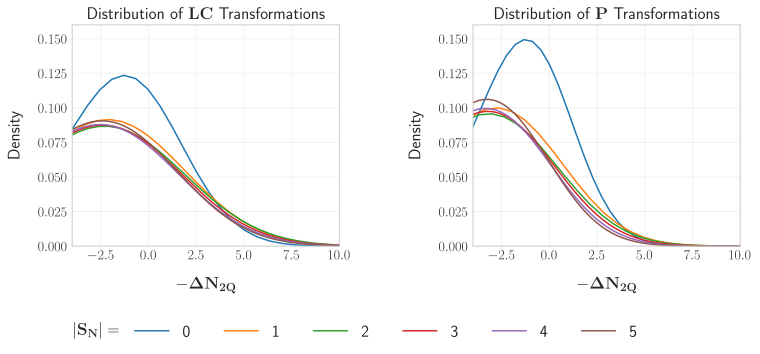

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
lpad = 15

ax = axes[0]
sub_df = all_matches_df.loc['lcomp']

for num_unf in sub_df.index.get_level_values('num_unf').unique():
    sub_df_num_unf = sub_df.loc[num_unf]
    sub_df_grouped = sub_df_num_unf.groupby('score').sum().reset_index()
    sns.kdeplot(x=sub_df_grouped['score'], weights=sub_df_grouped['total'], label=num_unf, lw=1.5, ax=ax, common_norm=False)

ax.set_title(r"Distribution of {\bf{LC}} Transformations")
ax.set_xlabel(r"$\bf-\Delta N_{2Q}$", labelpad=lpad)
ax.set_ylabel("Density", labelpad=lpad)
ax.set_xlim(-4, 10)
ax.set_ylim(0, 0.16)
ax.grid(color='#EEEEEE')

ax = axes[1]
sub_df = all_matches_df.loc['pivot']

for num_unf in sub_df.index.get_level_values('num_unf').unique():
    sub_df_num_unf = sub_df.loc[num_unf]
    sub_df_grouped = sub_df_num_unf.groupby('score').sum().reset_index()
    sns.kdeplot(x=sub_df_grouped['score'], weights=sub_df_grouped['total'], label=num_unf, lw=1.5, ax=ax, common_norm=False)

ax.set_title(r"Distribution of {\bf{P}} Transformations")
ax.set_xlabel(r"$\bf-\Delta N_{2Q}$", labelpad=lpad)
ax.set_ylabel("Density", labelpad=lpad)
ax.set_xlim(-4, 10)
ax.set_ylim(0, 0.16)
ax.grid(color='#EEEEEE')

plt.subplots_adjust(wspace=0.5)
plt.text(-1.5, -0.4, r'$\bf\left|S_N\right| = $', fontsize=17, transform=plt.gca().transAxes)
plt.legend(bbox_to_anchor=(0.18,-0.27), bbox_transform=fig.transFigure, ncol=6, loc="lower left", fancybox=True)
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/nu-dists.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

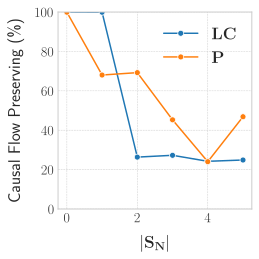

In [54]:
df = all_matches_df.copy()
df['percentage_flow_preserving'] = 100 * df['flow_preserving'] / (df['flow_preserving'] + df['non_flow_preserving'])

rewrites = df.index.get_level_values('rewrite').unique()

plt.figure(figsize=(4, 4))

sub_df = df.loc['lcomp']
sub_df_grouped = sub_df.groupby('num_unf').mean().reset_index()
sns.lineplot(data=sub_df_grouped, x='num_unf', y='percentage_flow_preserving', marker="o", label=r'\bf{LC}')
    
sub_df = df.loc['pivot']
sub_df_grouped = sub_df.groupby('num_unf').mean().reset_index()
sns.lineplot(data=sub_df_grouped, x='num_unf', y='percentage_flow_preserving', marker="o", label=r'\bf{P}')

plt.xlabel(r'$\bf\left|S_N\right|$', labelpad=10)
plt.ylabel(r"Causal Flow Preserving (\%)", labelpad=10)
plt.ylim(0, 100) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/cflow-preservating.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

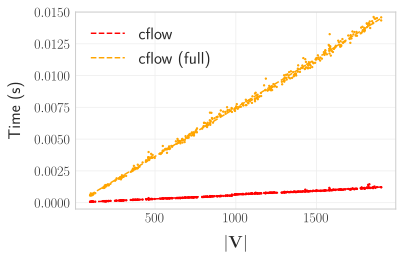

In [6]:
data = np.load('flow_times.npz')
num_vertices = np.array(data['num_vertices'].tolist())
num_edges = np.array(data['num_edges'].tolist())
gflow_time = np.array(data['gflow_time'].tolist())
cflow_time = np.array(data['cflow_time'].tolist())
cflow_full_time = np.array(data['cflow_full_time'].tolist())

x_fine = np.linspace(min(num_edges), max(num_edges), 400)
plt.figure(figsize=(6, 4))

cflow_coeffs = np.polyfit(num_edges, cflow_time, 2)
cflow_poly = np.poly1d(cflow_coeffs)
plt.scatter(num_edges, cflow_time, color='red', s=2)
plt.plot(x_fine, cflow_poly(x_fine), color='red', linestyle='--', label='cflow')

mask = cflow_full_time <= 0.1
filtered_num_edges = num_edges[mask]
filtered_cflow_full_time = cflow_full_time[mask]
cflow_full_coeffs = np.polyfit(filtered_num_edges, filtered_cflow_full_time, 2)
cflow_full_poly = np.poly1d(cflow_full_coeffs)
plt.scatter(filtered_num_edges, filtered_cflow_full_time, color='orange', s=2)
plt.plot(x_fine, cflow_full_poly(x_fine), color='orange', linestyle='--', label='cflow (full)')

plt.xlabel(r'$\bf\left|V\right|$', labelpad=10)
plt.ylabel('Time (s)',labelpad=10)
plt.ylim(-0.0005,0.015)
plt.legend()
plt.grid(color='#EEEEEE')
plt.tight_layout()
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/cflow-vs-full.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

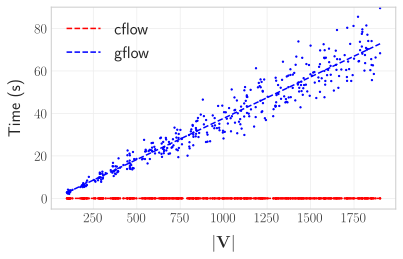

In [7]:
plt.figure(figsize=(6, 4))

cflow_coeffs = np.polyfit(num_edges, cflow_time, 2)
cflow_poly = np.poly1d(cflow_coeffs)
plt.scatter(num_edges, cflow_time, color='red', s=2)
plt.plot(x_fine, cflow_poly(x_fine), color='red', linestyle='--', label='cflow')

gflow_coeffs = np.polyfit(num_edges, gflow_time, 2)
gflow_poly = np.poly1d(gflow_coeffs)
plt.scatter(num_edges, gflow_time, color='blue', s=2)
plt.plot(x_fine, gflow_poly(x_fine), color='blue', linestyle='--', label='gflow')

plt.xlabel(r'$\bf\left|V\right|$', labelpad=10)
plt.ylabel('Time (s)',labelpad=10)
plt.ylim(-5,90)
plt.legend()
plt.grid(color='#EEEEEE')
plt.tight_layout()
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/cflow-vs-gflow.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [35]:
b = benchmark()
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking', 'Fast', 'before'), group_name='fast')
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking', 'Fast', 'nrscm'), group_name='fast', simp_strategy='NRSCM')

In [36]:
def basic_optimise(c):
    c1 = zx.optimize.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.optimize.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2
    return c1

def full_reduce(c):
    g = c.to_graph()
    zx.simplify.full_reduce(g,quiet=True)
    c2 = zx.extract_circuit(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def flow_optimise_g0(c):
    g = c.to_graph()
    zx.simplify.teleport_reduce(g)
    zx.simplify.to_graph_like(g, assert_bound_connections=False)
    zx.simplify.flow_2Q_simp(g, cFlow=False, rewrites=['id_fuse','lcomp','pivot'], max_lc_unfusions=0, max_p_unfusions=0)
    c2 = zx.extract_circuit(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def flow_optimise_c0(c):
    g = c.to_graph()
    zx.simplify.teleport_reduce(g)
    zx.simplify.to_graph_like(g, assert_bound_connections=False)
    zx.simplify.flow_2Q_simp(g, cFlow=True, rewrites=['id_fuse','lcomp','pivot'], max_lc_unfusions=0, max_p_unfusions=0)
    c2 = zx.extract_simple(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def flow_optimise_c1(c):
    g = c.to_graph()
    zx.simplify.teleport_reduce(g)
    zx.simplify.to_graph_like(g, assert_bound_connections=False)
    zx.simplify.flow_2Q_simp(g, cFlow=True, rewrites=['id_fuse','lcomp','pivot'], max_lc_unfusions=1, max_p_unfusions=1)
    c2 = zx.extract_simple(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def flow_optimise_c2(c):
    g = c.to_graph()
    zx.simplify.teleport_reduce(g)
    zx.simplify.to_graph_like(g, assert_bound_connections=False)
    zx.simplify.flow_2Q_simp(g, cFlow=True, rewrites=['id_fuse','lcomp','pivot'], max_lc_unfusions=2, max_p_unfusions=2)
    c2 = zx.extract_simple(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def zx_heur_g1(circ):
    c = zx_heuristics.Circuit.from_quipper(circ.to_quipper())
    g = c.to_graph()
    g = zx_heuristics.simplify.teleport_reduce(g)
    g.track_phases = False
    zx_heuristics.simplify.greedy_simp_neighbors(g)
    c2 = zx_heuristics.extract_circuit(g, up_to_perm=False).to_basic_gates()
    return basic_optimise(zx.Circuit.from_quipper(c2.to_quipper()))

def zx_heur_g0(circ):
    c = zx_heuristics.Circuit.from_quipper(circ.to_quipper())
    g = c.to_graph()
    g = zx_heuristics.simplify.teleport_reduce(g)
    g.track_phases = False
    zx_heuristics.simplify.greedy_simp(g)
    c2 = zx_heuristics.extract_circuit(g, up_to_perm=False).to_basic_gates()
    return basic_optimise(zx.Circuit.from_quipper(c2.to_quipper()))

In [37]:
b.add_simplification_func(func=full_reduce, name='\\texttt{full-reduce}', groups_to_run=None)
b.add_simplification_func(func=zx_heur_g0, name='\\texttt{ZX-heur (g$^0$)}', groups_to_run=None)
b.add_simplification_func(func=zx_heur_g1, name='\\texttt{ZX-heur (g$^1$)}', groups_to_run=None)
b.add_simplification_func(func=flow_optimise_g0, name='\\texttt{g$^0$}', groups_to_run=None)
b.add_simplification_func(func=flow_optimise_c0, name='\\texttt{c$^0$}', groups_to_run=None)
b.add_simplification_func(func=flow_optimise_c1, name='\\texttt{c$^1$}', groups_to_run=None)
b.add_simplification_func(func=flow_optimise_c2, name='\\texttt{c$^2$}', groups_to_run=None)

100%|██████████| 11/11 [00:00<00:00, 68.36it/s]


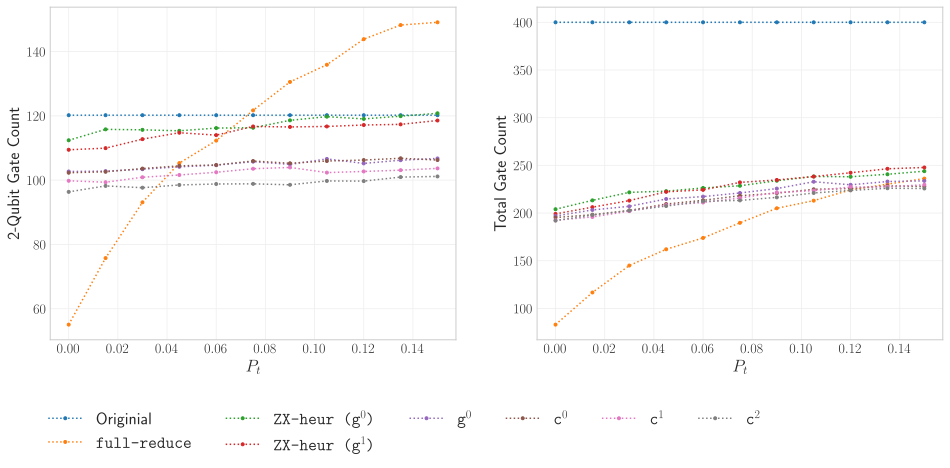

In [40]:
b = benchmark('pt_bench')
fig = b.Pt_graphs(funcs=['\\texttt{full-reduce}', '\\texttt{ZX-heur (g$^0$)}', '\\texttt{ZX-heur (g$^1$)}', '\\texttt{g$^0$}', '\\texttt{c$^0$}', '\\texttt{c$^1$}', '\\texttt{c$^2$}'], qubits=8, depth=400, cnot_prob=0.3, t_probs=[0.015*i for i in range(11)], ys=['2Q Count', 'Gates'], reps=20, figsize=[8,6], overwrite=False, random_seed=42)
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/gen-results.png', dpi=300, format='png', bbox_inches='tight')

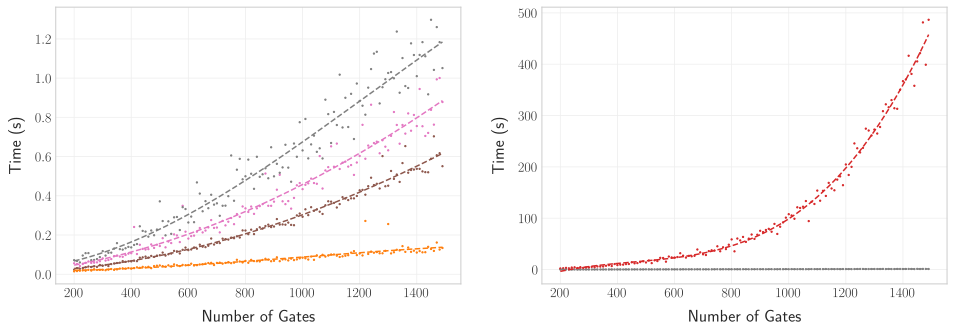

In [5]:
data = np.load('opt_times.npz')
c0s = data['c0s']
c1s = data['c1s']
c2s = data['c2s']
zx1s = data['zx1s']
frs = data['frs']
depths = data['depths']

def plot_scatter_and_fit(ax, x, y, colour, label):
    ax.scatter(x, y, color=colour, s=2)
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)
    ys = polynomial(x)
    ax.plot(x, ys, color=colour, label=label, linestyle='--')

# plt.figure(figsize=(8, 5))
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

plot_scatter_and_fit(axs[0], depths, c0s, 'C5', r'\texttt{c$^0$}')
plot_scatter_and_fit(axs[0], depths, c1s, 'C6', r'\texttt{c$^1$}')
plot_scatter_and_fit(axs[0], depths, c2s, 'C7', r'\texttt{c$^2$}')
# plot_scatter_and_fit(axs[0], depths, zx1s, 'C3', r'\texttt{ZX-heur (g$^1$)}')
plot_scatter_and_fit(axs[0], depths, frs, 'C1', r'\texttt{full-reduce}')

# plot_scatter_and_fit(axs[1], depths, c0s, 'C5', r'\texttt{c$^0$}')
# plot_scatter_and_fit(axs[1], depths, c1s, 'C6', r'\texttt{c$^1$}')
plot_scatter_and_fit(axs[1], depths, c2s, 'C7', r'\texttt{c$^2$}')
plot_scatter_and_fit(axs[1], depths, zx1s, 'C3', r'\texttt{ZX-heur (g$^1$)}')
# plot_scatter_and_fit(axs[1], depths, frs, 'C1', r'\texttt{full-reduce}')

axs[0].set_xlabel('Number of Gates', labelpad=10)
axs[0].set_ylabel('Time (s)', labelpad=10)
axs[1].set_xlabel('Number of Gates', labelpad=10)
axs[1].set_ylabel('Time (s)', labelpad=10)
# plt.legend()
axs[0].grid(color='#EEEEEE')
axs[1].grid(color='#EEEEEE')
plt.savefig('/Users/calum/Library/CloudStorage/OneDrive-Personal/Documents/Quantum Computing/flow-opt/graphics/gen-times.png', dpi=300, format='png', bbox_inches='tight')
plt.show()